# Assignment 3 - Building a Custom Visualization

The user will give an input in order to calculate the chance of it belonging to a particular year.   

The colors on the bars will represent such probability.  

---

## Instructions:

- Run the first cell and click inside the figure for the interaction to start!
- Click wherever you want to set the user yinput.


<IPython.core.display.Javascript object>


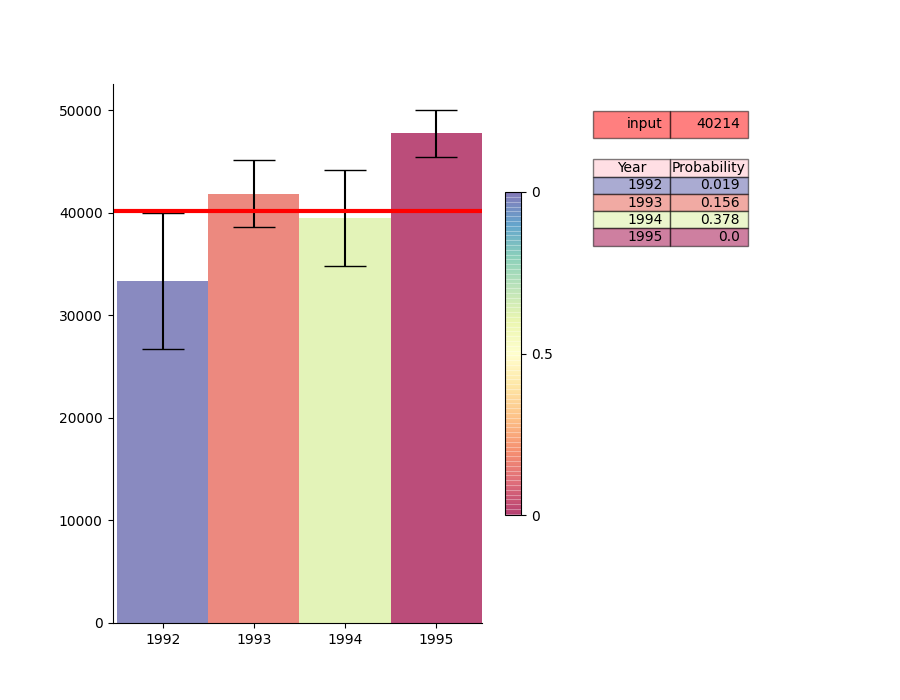

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

%matplotlib notebook

import scipy.stats as st
import numpy as np
import pandas as pd

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=["1992","1993","1994","1995"])

summary = df.T.loc[df.T.index].describe()

summary.loc["std"] = summary.loc["std"]/np.sqrt(summary.loc["count"]) 

def animated_plot(yinput):
    
    info = []
    fig = plt.figure(figsize=(9,7))
    ax = plt.subplot()
    gspec = gridspec.GridSpec(1, 12)
    bar = plt.subplot(gspec[:8])

    def onclick(event):
        bar.cla()
        
        #constants
        yinput = int(round(event.ydata, 0))
        width = 1
        xlabel = [str(i) for i in range(1992,1996)]

        #format the data
        x = range(1,5)
        y = [summary[item]["mean"] for item in xlabel]
        yerr = [2*summary[item]["std"] for item in xlabel]
        summary.loc["z"] = (yinput-summary.loc["mean"])/ summary.loc["std"]
        sum2 = summary.T
        sum2['prob'] = sum2['z'].apply(lambda x: 1-st.norm.cdf(abs(x)))
        sum2['colprob'] = sum2['z'].apply(lambda x: st.norm.cdf(x) if x > 0 else st.norm.cdf(x))
        probs = [i for i in round(sum2["prob"], 3)]
        info = [[xlabel[i], probs[i]] for i in range(4)]
        
        #Colormap
        bar_cols = my_cmap(sum2["colprob"])
        #sm.set_array([])

        #Plotting
        bar.bar(x,y, yerr=yerr, color=bar_cols, width=1, label=xlabel, capsize=15, alpha=0.7)
        bar.axhline(yinput, lw=3, color="red")



        #Probability Table
        p_table = bar.table(cellText=info, colLabels=["Year","Probability"],
                              bbox=[1.3, .7, 0.42, .16],
                              colColours=["Pink", "Pink"],
                              cellColours=[[i,i] for i in bar_cols])
        for cell in p_table._cells:
            p_table._cells[cell].set_alpha(.5)      

        #User Input Table
        input_t = bar.table(cellText=[["input",yinput]], bbox=[1.3, .9, 0.42, .05],
                            cellColours=[["red", "red"]])
        for cell in input_t._cells:
            input_t._cells[cell].set_alpha(.5)    
            input_t._cells[cell].set_width(1)
        
        #Colorbar
        
        #adjusting the axis
        bar.set_xlim([0.45,4.5])
        bar.set_xticks(x)
        bar.set_xticklabels(xlabel)
        bar.tick_params(which="both",bottom='off', labelleft='off', labelbottom='on')
        bar.spines["top"].set_visible(False)
        bar.spines["right"].set_visible(False)

    
    
    my_cmap = plt.cm.get_cmap('Spectral')
    normalize = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap=my_cmap, norm=normalize)
    sm.set_array([])

    plt.colorbar(sm, alpha=0.5, shrink=0.6, ticks=[0, .5, 1]).ax.set_yticklabels(['0', '0.5', '0'])

    fig.canvas.mpl_connect('button_press_event', onclick)   
    
    plt.show()

animated_plot(40000)

In [2]:
def plot_histograms():
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    plt.boxplot([df.T["1992"], df.T["1993"], df.T["1994"], df.T["1995"]], whis=1.5)
    plt.show()
    
#plot_histograms()

In [3]:
def simple_plot(yinput):
    
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot()
    
    #constants
    width = 1
    xlabel = [str(i) for i in range(1992,1996)]
    
    #format the data
    x = range(1,5)
    y = [summary[item]["mean"] for item in xlabel]
    yerr = [2*summary[item]["std"] for item in xlabel]
    summary.loc["z"] = (yinput-summary.loc["mean"])/ summary.loc["std"]
    sum2 = summary.T
    sum2['prob'] = sum2['z'].apply(lambda x: 1-st.norm.cdf(x))

    #Colormap
    my_cmap = plt.cm.get_cmap('gnuplot')
    bar_cols = my_cmap(sum2["prob"])
    sm = ScalarMappable(cmap=my_cmap )
    sm.set_array([])
    
    #Plotting
    plot = ax.bar(x,y, yerr=yerr, color=bar_cols, width=1, label=xlabel, capsize=15, alpha=0.7)
    line = ax.axhline(yinput, lw=3, color="red")
    cbar = plt.colorbar(sm, alpha=0.7)
        
    #adjusting the axis
    ax.set_xlim([0.45,4.5])
    ax.set_xticks(x)
    ax.set_xticklabels(xlabel)
    ax.tick_params(which="both",bottom='off', labelleft='off', labelbottom='on')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    #Probability Table
    probs = [[i] for i in round(sum2["prob"], 3)]
    p_table = ax.table(cellText=probs, colLabels=["Probability"],
                         rowLabels=xlabel, bbox=[1.3, .7, .12, .15],
                         rowColours=bar_cols, colColours=["Pink"],
                         cellColours=[[i] for i in bar_cols])
    for cell in p_table._cells:
        p_table._cells[cell].set_alpha(.5)      
        
    #User Input Table
    input_t = ax.table(cellText=[[yinput]], bbox=[1.3, .6, .12, .05],
                       rowLabels=["Input"], rowColours=["red"], cellColours=[["red"]])
    for cell in input_t._cells:
        input_t._cells[cell].set_alpha(.8)    
    
#simple_plot(40000)